# Feature Engineering and Machine Learning

***[Note: This notebook goes way beyond computing NDVI - I recommend changing the title to reflect that]***

## Introduction

RasterFrames is a powerful tool for combining geospatial data and Spark DataFrames. In this case study, we will walk through using RasterFrames and basic machine learning techniques available through [PySpark](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html) to analyze imagery containing both forested and developed land, and estimate the fraction of forest cover. This tutorial assumes a basic knowledge of DataFrames; more information can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes).

## Background

As humans expand across the planet, land that was once forested is cleared for other activities such as farming, livestock grazing, and logging. Such land is often high in biodiversity, and our forests are an essential component to our ecosystem. The rate at which they are being destroyed is only increasing ***[Is this true?]***. Gathering data on the rate of deforestation and forest degradation, as well as the precise regions in which they are occurring, allows scientists and authorities to combat illegal deforestation and affect policy change for forest management. Satellite data can be used to track deforestation. In this tutorial, we demonstrate how satellite imagery of regions within the Brazillian Amazon rainforest can be used to distinguish between forested and developed land.

***[Note: Throughout I tried to avoid the term "deforestation" because this notebook does not show how a user would identify forest cover change from sequential images.]***

## Initializing the Environment

We must first import the required Python modules. These include the `pyrasterframes` library and its functions that operate on RasterFrames, as well as `pyspark`, which is the processing backbone of `pyrasterframes`.

In [74]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession

Once the imports have been made, a `sparkSession` must be created. Note the `withRasterFrames()` method that is called which enables access to the `rasterframes` API.

In [75]:
spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()

## Reading in a RasterFrame

Once everything has been initialized, the next step is to read in our data. This example will use data in the form of a GeoTIFF, but there are other ways to create a RasterFrame, including from a GeoTrellis `Layer`, `ProjectedExtent`, or `tileLayerRDD` (see [creating-rasterframes.md]() for more info) ***[Link didn't work, not sure how to link to another internal doc - get help from Sim]***. In the case of a GeoTIFF, it's as simple as pointing `spark.read.geotiff` to the input file(s).

In [76]:
filePath = 'data/brazil_1/band2.tif'
initRF = spark.read.geotiff(filePath)

## Viewing a RasterFrame and Basic Statistics

Immediately, we can perform some basic functions on this RasterFrame. A brief `rf.show()` will demonstrate that a RasterFrame is very similar to a DataFrame, with named columns corresponding to certain attributes. For instance, `tile` contains all the cell values of the image, `bounds` contains the bounds of the GeoTIFF's geometry, etc. In this way, an image can be represented as a RasterFrame.

***[All of the RasterFrames created in this demo are a single tile. It would be more demonstrative to use a multi-row RasterFrame.]***

***[Use of the .show() method is good for a first look at what a RasterFrame is. May be good to explain a bit what the "ShortUserDefinedN..." means (isn't there a way to avoid truncating the text?). However, I'd really like to see something like the `showTileTables` method available in Zepplin from the aee repo. This is basically a feature request for rasterframes/pyrasterframes).]***

In [78]:
initRF.show()

+-----------+--------------------+--------------------+--------------------+
|spatial_key|              bounds|            metadata|                tile|
+-----------+--------------------+--------------------+--------------------+
|      [0,0]|POLYGON ((746445 ...|Map(Band_1 -> ban...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+



We can compuate some common statistics on the tile by calling `tileStats` on the tile. The output is an array with the number of cells, number of "no data" cells, minimum, maximum, mean, and variance, respectively. 

***[If we do change to a multi-tile RasterFrame, and example of aggregate stats would be nice as well.]***

In [42]:
initRF.select(tileStats("tile")).show(truncate = False)

+----------------------------------------------------------+
|tileStats(tile)                                           |
+----------------------------------------------------------+
|[51525,-1,125.0,726.0,237.8598544395925,4944.952683336407]|
+----------------------------------------------------------+



We can examine the cell type of the tiles with the `cellType` command. For these data, the cell type is a 16-bit integer. The "ud-9999" indicates that the "no data" value is set to -9999.

In [43]:
initRF.select(cellType("tile")).show()

+------------------------+
|celltypeexpression(tile)|
+------------------------+
|            int16ud-9999|
+------------------------+



Individual statistics about a tile can be obtained through a family of methods including `tileMean`, `tileSum`, `tileMin`, and others. You'll notice the output of `tileMean` is consistent with the mean value found with `tileStats`.

In [79]:
initRF.select(tileMean("tile")).show()

+------------------+
|    tileMean(tile)|
+------------------+
|237.85985443959243|
+------------------+



## Loading Multiple Bands

The image used here originally comes from a multiband image from the Landsat 8 satellite. However, the bands have been split up and saved into single-band GeoTIFFs. We will load in each band individually for the purpose of demonstrating how to perform spatial joins to get all the bands into a single RasterFrame. We will load in in bands 2 through 5, which correspond to the blue, green, red, and NIR bands on the [Landsat 8 OLI](https://lta.cr.usgs.gov/L8), respectively.

`spatialJoin` is a DataFrame ***[RasterFrame?]*** operation that joins on a spatial_key column. Bounds and metadata are discarded because they are no longer needed for the analysis.

This project analyzes three separate scenes, all captured in close proximity to each other in the Brazilian rainforest. The background of this image is the green band, and all three sites appear to contain both forested and developed land types.

![Pic](pics/site_locs.png)

***[Similar to a previous comment, I think we could revise the structure of the RasterFrame to better speak to the "good ergonomics" goal of the API. I think it would be better if all three scenes could be loaded into a single RasterFrame (per band). This would probably mean storing the source data in a different way.]***

***[Bascially, what this tutorial doesn't demonstrate in my mind is a key concept in RasterFrames - that you can treat the whole RasterFrame as a single image. The way the scenes are broken up into three different RasterFrames means that we're treating them as individual images, and later on building three different clustering models on them. From a data science perspective that doesn't make much sense. Doing this would also greatly simplify all of the code downstream of this tutorial.]***

***[Regarding the code block to "Join those singleband rasterframes together into a multiband RF", I'm not a big fan of using a lambda function here. I do think some of the users would naturally do this, but lambda functions in general are for more experienced developers, and I'd prefer to lower the bar in our tutorials. But that's just my two cents.]***

In [45]:
# Three scenes
scene_nums = range(1, 4)
# Four bands per scene (2, 3, 4, and 5)
band_nums = range(2, 6)

filePattern = 'data/brazil_{0}/band{1}.tif'

def readTiff(name):
    return spark.read.geotiff(name)

In [46]:
from functools import reduce

#Start from the bottom

# Join those singleband rasterframes together into a multiband RF
fullRFs = [reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2), 
    # Map those tuples to the singleband rasterframe file with the default "tile" column renamed  
    [readTiff(bf[1]).withColumnRenamed('tile', 'band_{}'.format(bf[0])) for bf in \
    # Map the bandNumbers to (bandNumber, formatted file name) tuples
    [(bn, filePattern.format(sn, bn)) for bn in band_nums]]) \
    # Drop unnecessary columns
    .drop('bounds').drop('metadata') for sn in scene_nums]

As you can see, all four bands of all three scenes are now loaded into three seperate RasterFrames.

In [47]:
for rf in fullRFs:
    rf.asRF().show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+-----

It is possible to display the center of the extent of the tile in (Lat, Long) format using `withCenterLatLng`, as shown below. Additionally, the method `withCenter` will display it in the native CRS. Other useful methods include `withBounds` and `withSpatialIndex` (not demonstrated here).

In [48]:
for rf in fullRFs:
    rf.asRF().withCenterLatLng().select("center").show(truncate=False)

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.72875437318221,-8.829838122908235]|
+---------------------------------------+

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.96294012022688,-8.904540118090805]|
+---------------------------------------+

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.89073947264485,-8.725024074332008]|
+---------------------------------------+



## Tile Arithmetic for Feature Engineering

Here we show how to do tile arithmetic to create new columns in a RasterFrame. We compute various local map algebra functions, which take one or more bands as inputs and transforms every cell individually. The output of a local map algebra function is therefore a tile of the same size as the input tiles. Here we use several local functions to create new features that we use later to build a machine learning model.

![](../../local-functions.gif)

We first compute the normalized difference vegetation index [NDVI](https://earthobservatory.nasa.gov/Features/MeasuringVegetation/measuring_vegetation_2.php), which is a metric computed from the red (band 4) and NIR (band 5). `normalizedDifference` is a `rasterframes` function that is equivalent to $\frac{NIR - Red}{NIR + Red}$. Since the cell types of Landsat bands are integers, we must also convert them to floats using `convertCellType`, which changes the data type of the cells in a tile, in order to return decimal values when dividing.

In [49]:
ndviRFs = [rf.withColumn("ndvi",normalizedDifference(
    convertCellType('band_5', 'float32'), 
    convertCellType('band_4', 'float32'))) for rf in fullRFs]

We next compute the sum of the green and blue bands to use in our clustering model. `localAdd` is part of a family of arithemtic functions, and it adds the values of every specified band together. There also exists local scalar arithmetic functions, which you must append "Int" to to use with an integer.

***[These features don't make much sense for machine learning. Let's talk about why, and come up with replacement that can help demonstrate the local map algebra functions.]***

In [50]:
gbRFs = [rf.withColumn("green+blue", localAdd("band_3", "band_2")) for rf in ndviRFs]
g2RFs = [rf.withColumn("green*2", localMultiplyScalarInt("band_3", 2)) for rf in gbRFs]
completedRFs = [rf.withColumn("NIR-blue", localSubtract("band_5", "band_2")) for rf in g2RFs]

In [80]:
for rf in completedRFs:
    rf.select(tileStats("ndvi")).show(truncate = False)

+----------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                         |
+----------------------------------------------------------------------------------------+
|[51525,-1,0.2584196925163269,0.9273137450218201,0.8077649412792555,0.008396342462181239]|
+----------------------------------------------------------------------------------------+

+---------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                        |
+---------------------------------------------------------------------------------------+
|[57072,-1,-0.5266343951225281,0.914093017578125,0.7854701653986633,0.01124415954480573]|
+---------------------------------------------------------------------------------------+

+-----------------------------------------------------------------------------------------+
|

## Machine Learning

The purpose of this exercise is to determine the fraction of forest cover in the selected areas in a procedural way. To this end, we will use a straightforward [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering algorithm available to us through PySparkML. The k-means algorithm works by grouping the cells based on the similarity of their band features.

SparkML uses the concept of a "pipeline" for building machine learning models, which defines the full series of steps required.

### Explode and Vectorize the Tiles

PySparkML requires that each observation be in its own row, and all of the model inputs be packed into a single feature `Vector`. The first step is to "explode" the tiles into a single row per cell/pixel.

In [81]:
exploder = TileExploder()

The next step is take the input features in seperate columns and assemble them into a single feature vector. PySparkML has a tool for this called a `VectorAssembler` which has as inputs a certain number of columns of features and outputs a single column with the vectorized features in it.

In [82]:
from pyspark.ml.feature import VectorAssembler

band_col_names = ["band_{}".format(x) for x in band_nums]
assembler = VectorAssembler() \
    .setInputCols(band_col_names + [("ndvi")] + [("green+blue")] + [("green*2")] + [("NIR-blue")]) \
    .setOutputCol("features")

### Fit a K-means Clustering Model

We next specify the machine learning algorithm to use and its parameters. For our example we set the number of clusters to 2, because we seek simply to differentiate between forested area and non-forested area. ***[But it's set to 3 below - which is correct?]***

***[As mentioned above, you're actually fitting three different K-means models for the three different scenes. This isn't what would be typically done for the problem at hand.]***

In [83]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

kmeans = KMeans().setK(3)

# We establish our pipeline with our stages
pipeline = Pipeline().setStages([exploder, assembler, kmeans])

Finally, we fit our model and determine the clusters.

In [84]:
models = [pipeline.fit(rf) for rd in completedRFs]

Upon fitting the model and transforming the data, the returned DataFrame consists of one cell per row. In addition, there is now a prediction column that contains the result of the model - in this case, an integer indicating which cluster the cell belongs to.

***[Can you add more text to describe what you're downing in the next two paragraphs?]***

In [57]:
rf_model_zip = list(zip(completedRFs, models))

In [58]:
clusteredRFs = [rf_models[1].transform(rf_models[0]) for rf_models in rf_model_zip]
clusteredRFs[0].show(3)

+-----------+------------+---------+------+------+------+------+------------------+----------+-------+--------+--------------------+----------+
|spatial_key|column_index|row_index|band_2|band_3|band_4|band_5|              ndvi|green+blue|green*2|NIR-blue|            features|prediction|
+-----------+------------+---------+------+------+------+------+------------------+----------+-------+--------+--------------------+----------+
|      [0,0]|           0|        0| 188.0| 349.0| 206.0|2750.0|0.8606224656105042|     537.0|  698.0|  2562.0|[188.0,349.0,206....|         1|
|      [0,0]|           1|        0| 184.0| 340.0| 207.0|2837.0|0.8639947175979614|     524.0|  680.0|  2653.0|[184.0,340.0,207....|         1|
|      [0,0]|           2|        0| 196.0| 356.0| 227.0|2856.0|0.8527408242225647|     552.0|  712.0|  2660.0|[196.0,356.0,227....|         1|
+-----------+------------+---------+------+------+------+------+------------------+----------+-------+--------+--------------------+----

### View the Model Results

In order to visualize the predictions of our model, we must first convert the exploded version of the tile back into an actual tile.

***[Would be nice to explain what this code is doing in more detail. Or if covered in another tutorial, add a link.]***

***From here, the code needed for visualization gets really complex, to the point of distraction. It's more like a lesson in numpy and matplotlib. I recommend either removing the visualization entirely and simply computing the fraction of forest cover, or adding a method like `showTileTables` that can provide a quick look at the results.]***

In [59]:
tiledRFs = list()
for i in range(0, 3):
    tlm = completedRFs[i].asRF().tileLayerMetadata()
    layout = tlm['layoutDefinition']['tileLayout']

    retiled = clusteredRFs[i].groupBy('spatial_key').agg(
        assembleTile('column_index', 'row_index', 'prediction',
        layout['tileCols'], layout['tileRows'], 'int16'))
        
    tiledRFs.append(retiled)

In [60]:
predRFs = [rf.asRF('spatial_key', tlm) for rf in tiledRFs]
for rf in predRFs:
    rf.show(3)

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+



To render our visualization, we convert to a raster first, which gives us a 1-D array with all the cell values. We then reshape the raster into a 2d array and use an
matplotlib colormap to assign each discrete cluster a different color.

In [61]:
resolutions = ((229, 225), (232, 246), (235, 231))

Zip the prediction RFs and their respective resolutions to prepare to render them

In [62]:
zip_preds_res = list(zip(predRFs, resolutions))

Create a one dimensional array from the prediction data

In [63]:
import numpy as np
rasters = [np.asarray(list(pred_res[0].
          toIntRaster('prediction', pred_res[1][1], pred_res[1][0]))) for pred_res in zip_preds_res]

In [64]:
# Zip the prediction RFs and their respective resolutions to prepare to render them
zipRasterResolution = list(zip(rasters, resolutions))

In [65]:
pixels = [np.reshape(RasRes[0], RasRes[1]) for RasRes in zipRasterResolution]

In [66]:
pixels[2]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

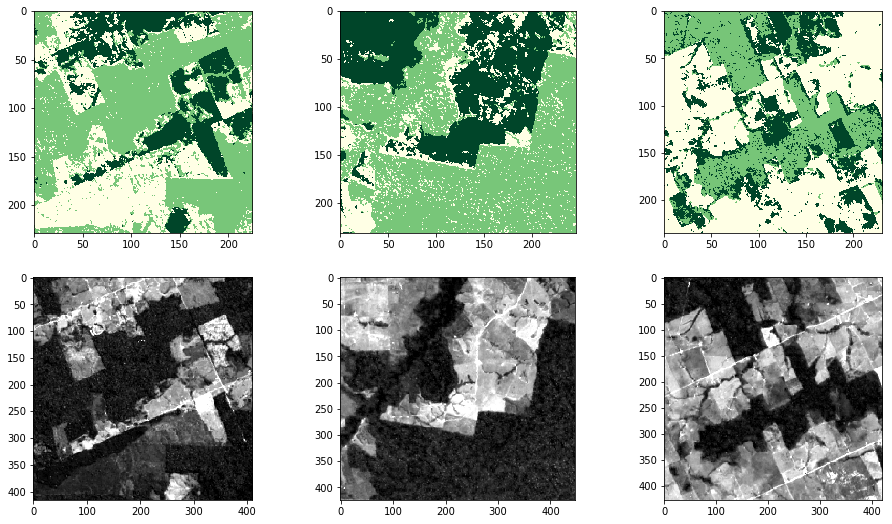

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot the images
cmap = "YlGn_r"
fig = plt.figure(figsize=(16,9))
fig.add_subplot(2, 3, 1)
plt.imshow(pixels[0])
plt.set_cmap(cmap)
fig.add_subplot(2, 3, 2)
plt.imshow(pixels[1])
plt.set_cmap(cmap)
# Flip the colormap because the last scene has the cluster values reversed
cmap = "YlGn"
fig.add_subplot(2, 3, 3)
plt.imshow(pixels[2])
plt.set_cmap(cmap)

fig.add_subplot(2, 3, 4)
pixels4 = mpl.pyplot.imread("pics/brazil1-green.png")
imgplot = plt.imshow(pixels4)
fig.add_subplot(2, 3, 5)
pixels5 = mpl.pyplot.imread("pics/brazil2-green.png")
imgplot = plt.imshow(pixels5)
fig.add_subplot(2, 3, 6)
pixels6 = mpl.pyplot.imread("pics/brazil3-green.png")
imgplot = plt.imshow(pixels6)

As you can see, the dark green represents forest, with the other two shades representing land that is cleared to some degree. Now let's access more precise statistics about this use.

***[I don't understand what the `tileHistogram` results are at all. Needs more explanation]***

In [68]:
predRFs[2].select(tileHistogram("prediction")).show(truncate = False)

+--------------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                     |
+--------------------------------------------------------------------------------------------------------------+
|[[54285,-1,0.0,2.0,0.7394676245740075,0.6633193444662465],WrappedArray([0.0,26918], [1.0,14592], [2.0,12775])]|
+--------------------------------------------------------------------------------------------------------------+



In [69]:
predRFs[0].select(tileHistogram("prediction")).show(truncate = False)

+--------------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                     |
+--------------------------------------------------------------------------------------------------------------+
|[[51525,-1,0.0,2.0,1.1140417273168366,0.5247916702627125],WrappedArray([0.0,10917], [1.0,23815], [2.0,16793])]|
+--------------------------------------------------------------------------------------------------------------+



### Computing Fraction of Forest Cover

In these examples, it appears that a value of zero (Dark Green in the colormap) represents forest. Let's find the percentage of land covered by forest in these examples. Recall that rasters is the list of one dimensional arrays containing all the prediction values for the three scenes.

In [70]:
# Returns the number of cells that we believe the model marked similarly to forest
forest1 = np.count_nonzero(rasters[0] == 0)
forest2 = np.count_nonzero(rasters[1] == 0)
# The third scene has the clusters reversed, so we look for values of 2
forest3 = np.count_nonzero(rasters[2] == 2)

In the first scene, a little less than half of the scene is composed of the values that resemble rainforest (according to the model).

In [71]:
# Number of forest divided by the total
forest1 / len(rasters[0])

0.21187772925764192

In [72]:
# Total forest cells for all three scenes, divided by total cells
(forest1 + forest2 + forest3) / (len(rasters[0]) + len(rasters[1]) + len(rasters[2]))

0.25658452130990533

In total, it appears that less than 40 percent of the area surveyed in these three scenes is forested. While there are improvements to be made, this algorithm could easily be adapted to survey land of any size. Landsat 8 has a temporal resolution of 16 days, and tracking these numbers over time could give an estimate of the rate of change of deforestation in a certain area, or with enough compute power, the entire Amazon Rainforest.